In [ ]:
# google.colab에 drive를 mount
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive//MyDrive/PDE'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1KgOE4_n0K-jHmJCGQUIQq6y3Bh7KWHwB/PDE


In [ ]:
#optuna: hyperparameter 찾기에 좋은 library
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import optuna
import random


import matplotlib.pyplot as plt
import importlib
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
%reload_ext autoreload
from utils import *

# Utils functions

PDE Dimension(excluding t) : 2
Number of collocation points : 2500
x_min : 0
x_max : 1
test_x_grid_num : 20
y_min : 0
y_max : 1
test_y_grid_num : 20
t_max : 1
test_t_grid_num : 20
cha_num: 50
Number of boundary conditions: 4
Boundary 1
Boundary for x or y? (x/y) : x
Boundary1 : x = 0
Boundary 2
Boundary for x or y? (x/y) : x
Boundary2 : x = 1
Boundary 3
Boundary for x or y? (x/y) : y
Boundary3 : y = 0
Boundary 4
Boundary for x or y? (x/y) : y
Boundary4 : y = 1
boundary/initial points rato (%) : 20
torch.Size([500, 3])
Total sampled points : 5000


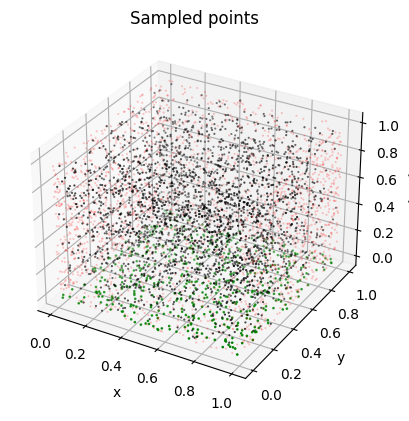

In [ ]:
# point_sampler를 통해 다음 과정을 거침
# 1. points_dict: training에 사용할 점들을 random으로 sampling
# 2. test_dict: test에 이용할 점들을 uniform grid로 생성
# 3. points_dict_cha: characteristic_loss를 training시키기 위한 점들을 생성
points_dict, test_dict, points_dict_cha = point_sampler()
# collocation points: pde_loss학습에 필요한 sample 개수 생성
# _min, _max: 근사해를 구할 범위
# grid_num은 x,y,t축마다 test에 입력할 grid 격자점 개수
# cha_num: characteristic_loss를 학습시키기 위한 sample수
# Boundary/initial points ratio: sample*(변수%)로 Boundary/initial points 생성

In [ ]:
#linear_condition: inviscid form 2D burger's equation에서 초기값을 u(x,y,0)=ax+by, v(x,y,0)=cx+dy라 했을 때의 상황
class linear_condition():
  def __init__(self,coef):
    self.a = coef[0]
    self.b = coef[1]
    self.c = coef[2]
    self.d = coef[3]
    self.D = self.a*self.d - self.b*self.c

  # analytic solution을 계산하는 함수
  def analytic_solution(self,batch):
    x = batch[:,0]
    y = batch[:,1]
    t = batch[:,2]

    denominator = self.D*(t**2) + (self.a+self.d)*t + 1

    u = (((self.D * t + self.a)*x + self.b * y)/denominator).unsqueeze(dim=-1)
    v = (((self.D * t + self.d)*y + self.c * x)/denominator).unsqueeze(dim=-1)

    result = torch.cat((u,v), dim=-1)

    return result

  # initial condition에 해당하는 u, v를 계산하는 함수
  def initial_condition(self,initial_points):
    return self.analytic_solution(initial_points)
  # boundary condition에 해당하는 u, v를 계산하는 함수
  def boundary_condition(self,boundary_points):
    return self.analytic_solution(boundary_points)


#known_condtion: analytic solution을 알고 있을 때의 상황, 나머지 함수들은 위와 동일한 기능을 함
class known_condition():

  def analytic_solution(self,batch):
    x = batch[:,0].unsqueeze(dim = -1)
    y = batch[:,1].unsqueeze(dim = -1)
    t = batch[:,2].unsqueeze(dim = -1)
    u =  torch.zeros_like(x)
    u[x<t]=2.
    v =  torch.zeros_like(x)

    result = torch.cat((u,v), dim=-1)

    return result

  def initial_condition(self,initial_points):
    return self.analytic_solution(initial_points)

  def boundary_condition(self,boundary_points):
    return self.analytic_solution(boundary_points)

#unknown_condtion: analytic solution을 모르고 있을 때의 상황, 나머지 함수들은 위와 동일한 기능을 함
class unknown_condition():

  def initial_condition(self,initial_points):
    x = initial_points[:,0].unsqueeze(dim = -1)
    y = initial_points[:,1].unsqueeze(dim = -1)
    t = initial_points[:,2].unsqueeze(dim = -1)

    initial_condition1 = None
    initial_condition2 = None

    return torch.cat((initial_condition1, initial_condition2), dim = -1)

  def boundary_condtion1(self,boundary_points):
    x = None
    y = None
    t = None

    boundary_condition1 = None
    boundary_condition2 = None

    return torch.cat((boundary_condition1, boundary_condition2), dim = -1)










In [ ]:
# 위의 class에서 실제로 사용할 상황을 정의한 후, 객체 생성
condition = linear_condition([1,-3,1,-2])

# Define dataset and network

In [ ]:
class CustomDataset(Dataset):
  def __init__(self,col_x_y_t):
    self.col_x_y_t = col_x_y_t


  def __len__(self):
    return len(self.col_x_y_t)

  def __getitem__(self,idx):
    return self.col_x_y_t[idx]

In [ ]:
# PINN model: linear layer, tanh 를 번갈아가며 반복하여 생성
def define_model(trial):
  layers = []
  input_dim = 3
  output_dim = 2
  features = 48
  num = 10
  layers.append(nn.Linear(input_dim, features))
  layers.append(nn.Tanh())
  for i in range(num-1):
    layers.append(nn.Linear(features, features))
    layers.append(nn.Tanh())

  layers.append(nn.Linear(features, output_dim))

  return nn.Sequential(*layers)

# Define loss function

In [ ]:
def loss_fn(batch, model, points_dict, condition, device, loss_ratio):
# condition 수정할 땐 들어가야함
  # Loss metric
  mse = nn.MSELoss().to(device)

  # Forward
  batch = batch.requires_grad_(True).to(device)
  initial_points = points_dict['initial'].to(device)
  boundary_points = points_dict['boundary'].to(device)

  pde_out = model(batch)
  initial_out = model(initial_points)
  boundary_out = model(boundary_points)


  # First order partial derivative
  du = torch.autograd.grad(outputs = pde_out[:,0], inputs = batch, grad_outputs=torch.ones_like(pde_out[:,0]), create_graph = True)
  dv = torch.autograd.grad(outputs = pde_out[:,1], inputs = batch, grad_outputs=torch.ones_like(pde_out[:,1]), create_graph = True)

  u_x = du[0][:,0]
  u_y = du[0][:,1]
  u_t = du[0][:,2]

  v_x = dv[0][:,0]
  v_y = dv[0][:,1]
  v_t = dv[0][:,2]

  # Second order partial derivative
  u_xx = torch.autograd.grad(outputs = du[0][:,0], inputs = batch, grad_outputs = torch.ones_like(du[0][:,0]), create_graph = True)[0][:,0]
  u_yy = torch.autograd.grad(outputs = du[0][:,1], inputs = batch, grad_outputs = torch.ones_like(du[0][:,1]), create_graph = True)[0][:,1]

  v_xx = torch.autograd.grad(outputs = dv[0][:,0], inputs = batch, grad_outputs = torch.ones_like(dv[0][:,0]), create_graph = True)[0][:,0]
  v_yy = torch.autograd.grad(outputs = dv[0][:,1], inputs = batch, grad_outputs = torch.ones_like(dv[0][:,1]), create_graph = True)[0][:,1]

  # PDE loss

  nu = 0
  pde_u = u_t+pde_out[:,0]*u_x + pde_out[:,1]*u_y -nu*(u_xx+u_yy)
  pde_v = v_t + pde_out[:,0]*v_x + pde_out[:,1]*v_y- nu*(v_xx+v_yy)
  pde_loss = mse(pde_u, torch.zeros_like(pde_u)) + mse(pde_v, torch.zeros_like(pde_v))


  pde_loss_tensor = pde_u**2 + pde_v**2 # This is for RAR criteria

  # Initial condition loss
  initial_loss = mse(initial_out, condition.initial_condition(initial_points)) + mse(boundary_out, condition.boundary_condition(boundary_points))

  # Sum all losses
  total_loss = pde_loss * (1-loss_ratio) + initial_loss * loss_ratio

  return pde_loss, initial_loss, pde_loss_tensor, total_loss


In [ ]:
# inviscid burger's equation에서는 모든 점마다 그 점을 지나는 characteristic line이 존재함
# smooth한 solution이 존재한다면 임의의 u,v에 대해
def cha_loss_fn(model, points_dict_cha, device):
  mse = nn.MSELoss().to(device)
  col_points_cha = points_dict_cha['collocation'].to(device)
  initial_points_cha = points_dict_cha['initial'].to(device)

  batch_total_col=torch.cat((col_points_cha,model(col_points_cha).detach()),dim=-1)
  batch_total_ini=torch.cat((initial_points_cha,model(initial_points_cha).detach()),dim=-1)


  t_n = torch.linspace(0,1,50).repeat(50).to(device)

  x_n_col = (batch_total_col[:,3] * (t_n - batch_total_col[:,2]) + batch_total_col[:,0]).unsqueeze(dim = -1)
  y_n_col = (batch_total_col[:,4] * (t_n - batch_total_col[:,2]) + batch_total_col[:,1]).unsqueeze(dim = -1)

  x_n_ini = (batch_total_ini[:,3] * (t_n - batch_total_ini[:,2]) + batch_total_ini[:,0]).unsqueeze(dim = -1)
  y_n_ini = (batch_total_ini[:,4] * (t_n - batch_total_ini[:,2]) + batch_total_ini[:,1]).unsqueeze(dim = -1)

  newsample_col = torch.cat((x_n_col,y_n_col,t_n.unsqueeze(dim = -1)), dim = -1)
  newsample_ini = torch.cat((x_n_ini,y_n_ini,t_n.unsqueeze(dim = -1)), dim = -1)

  real_value_col = batch_total_col[:,3:]
  real_value_ini = batch_total_ini[:,3:]

  predict_col = model(newsample_col)
  predict_ini = model(newsample_ini)

  charac_loss_col = mse(real_value_col, predict_col)
  charac_loss_ini = mse(real_value_ini, predict_ini)
  return charac_loss_col, charac_loss_ini


In [ ]:
def RAR(num,model,pde_loss, device, loss_ratio):
    # Collocation datapoints
    # num = 20000//(2**(epoch_cnt//100)) # Decreasing sampling points over epochs
    col_x_acce = torch.linspace(0, 0.5, num)[torch.randperm(num)].unsqueeze(dim = -1)
    col_y_acce = torch.linspace(0, 0.5, num)[torch.randperm(num)].unsqueeze(dim = -1)
    col_t_acce = torch.linspace(0, 0.7, num)[torch.randperm(num)].unsqueeze(dim = -1)

    col_acce = torch.cat((col_x_acce, col_y_acce, col_t_acce), dim = -1).requires_grad_(True).to(device)


    # PDE loss for new datapoints

    _,_,pde_loss_acce,_ = loss_fn(col_acce, model, points_dict, condition, device, loss_ratio)

    # Sample datapoints which pde loss is larger than given pde_loss
    criteria = pde_loss_acce - pde_loss
    sampled_col_points = col_acce[criteria > 0].detach()

    return sampled_col_points

# Train

##  Adam

In [ ]:
def objective(trial):
  device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
  num_epochs = 10000
  num_0 = 2500
  loss_ratio = 0.927626907581494
  loss_ratio_cha_col= 0
  loss_ratio_cha_ini= 0
  num_category = trial.suggest_categorical("num_category", ["exponential"])
  cha_con = 0
  model = define_model(trial)
  model = model.to(device)
  optimizer = optim.Adam(model.parameters(), lr = 1E-4)
  col_x_y_t = points_dict['collocation']
  custom_dataset = CustomDataset(col_x_y_t)
  dataloader = DataLoader(custom_dataset, batch_size=512, shuffle = True)
  model.train()

  print(f'CURRENT_DEVICE : {device}')
  for epoch_cnt in range(1,num_epochs):
    if epoch_cnt % 1000 == 0:
      print(f'EPOCH {epoch_cnt}')
      total_loss = 0

      if num_category == "constant":
          num = num_0
      elif num_category == "fraction":
          num = (num_0)//(epoch_cnt//2)
      elif num_category == "exponential":
          num = (2*num_0)//(2**(epoch_cnt//2))
      if num_category != "zero":
        rar_loss,_,_,_ = loss_fn(test_dict['collocation'], model, test_dict, condition, device, loss_ratio)
        sampled_col_points = RAR(num, model, rar_loss, device, loss_ratio)
        print(f'NUMBER_OF_SAMPLED_POINTS : {sampled_col_points.shape[0]}')
        col_x_y_t = torch.cat((col_x_y_t.to(device), sampled_col_points), dim = 0)

        custom_dataset = CustomDataset(col_x_y_t)
        dataloader = DataLoader(custom_dataset, batch_size = 512, shuffle = True)


    for batch in dataloader:
      _,_,_,loss = loss_fn(batch, model,points_dict,condition,device,loss_ratio)

      if cha_con !=0:
        cha_loss_col, cha_loss_ini =cha_loss_fn(model, points_dict_cha, device)

      if cha_con ==1:
        loss += cha_loss_col
      elif cha_con ==2:
        loss += cha_loss_ini
      elif cha_con ==3:
        loss += loss_ratio_cha_col*cha_loss_col
        loss += loss_ratio_cha_ini*cha_loss_ini


      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if epoch_cnt % 1000 == 0:
        total_loss += loss.item()

    if epoch_cnt % 1000 == 0:
      print(f'LOSS : {total_loss}')
      validate_visualization(model, device, condition, observe_t = [0.0,0.2,0.4,0.6,0.8,1.0], x_range = [0.0,1.0], y_range = [0.0,1.0])
      torch.save(model, f'./pt/2D_BURGERS_EPOCH_{epoch_cnt}_linear_condition.pt')
  torch.save(model, f'./pt/2D_BURGERS_EPOCH_LAST_linear_condition.pt')
  validate_visualization(model, device, condition, observe_t = [0.0,0.2,0.4,0.6,0.8,1.0], x_range = [0.0,1.0], y_range = [0.0,1.0])
  if cha_con != 0:
    print(cha_loss_fn(model, points_dict_cha, device))
  return real_test(test_dict, model, loss_ratio, loss_fn, condition, device)

In [ ]:
study=optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)
study.best_params

In [ ]:
optuna.visualization.plot_slice(study)
